# Exercise 19: Backpropagation for fully connected neural networks

Here we test backpropagation for fully connected neural networks. We assume $L$ layers.

Final layer is a binary classification layer (sigmoid output, binary cross entropy loss).

Intermediate layers are ReLU layers.

Let's try training on some synthetic data (such as an annulus).

## Training data

First, let's synthesize some data:

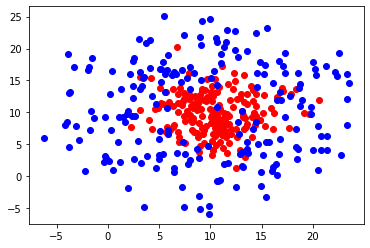

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# Gaussian center of the annulus

m_per_class = 200

mu = np.array([10, 10])
sigma = np.array([[10, 0], [0, 10]])
X1 = np.random.multivariate_normal(mu, sigma, m_per_class)

# Outer ring of annulus

r = 10
sigma = 3
theta = np.random.uniform(0, 2 * np.pi, m_per_class)
r = r + np.random.normal(0, sigma, m_per_class)
x, y = 10 + np.cos(theta) * r, 10 + np.sin(theta) * r
X2 = np.concatenate((x.reshape(-1, 1), y.reshape(-1, 1)), 1)

plt.plot(X1[:,0], X1[:,1], 'ro')
plt.plot(X2[:,0], X2[:,1], 'bo')
plt.show()

## Neural network architecture

Now we define the architecture. We need some data structures:
weights, biases, activation functions, linear activations, nonlinear activations, deltas.

The shape of these all depend on how many units we have per layer.

Let's try a model consisting of the two inputs ($x_1$ and $x_2$), two hidden layers,
and an output layer. Let's use 4 units in layer 1 and 3 units in layer 2. Since layer
3 is the output layer and we have a binary classification problem, the output layer will
have just one sigmoid unit. We'll use ReLU for the hidden layers.

For the shape of the weight matrices and bias vectors:
- $\mathtt{W}^{[1]}: 4 \times 2$
- $\mathbf{b}^{[1]}: 4 \times 1$
- $\mathtt{W}^{[2]}: 3 \times 4$
- $\mathbf{b}^{[2]}: 3 \times 1$
- $\mathtt{W}^{[3]}: 1 \times 3$
- $\mathbf{b}^{[3]}: 1 \times 1$

How should we initialize the weights? There are two main ways:
- Small random normal values with mean 0
- Xavier-He initialization

We'll just use the small random normal values. We'll initialize ReLU biases to 0.5
and the sigmoid bias to 0, to keep the expected linear activation in the region where
the activations have maximal slope.

Let's use Python dictionaries to store $\texttt{W}^{[l]}$ and $\mathbf{b}^{[l]}$.

As a slightly advanced technique, we'll also use dictionaries to store the
nonlinear activation function for each layer $g(\cdot)$ and the activation functions'
derivatives $g'(\cdot)$.

In [2]:
W = {}
W[1] = np.random.normal(0, 0.1, (4, 2))
W[2] = np.random.normal(0, 0.1, (3, 4))
W[3] = np.random.normal(0, 0.1, (1, 3))

b = {}
b[1] = np.zeros((4, 1)) + 0.5
b[2] = np.zeros((3, 1)) + 0.5
b[3] = np.zeros((1, 1))

def sigmoid(z):
    return 1 / (1 + np.exp(-z))

def sigmoid_der(z):
    a = sigmoid(z)
    return a * (1 - a)

def relu(z):
    return np.where(z > 0, z, 0)

def relu_der(z):
    return np.where(z > 0, 1, 0)

g = {}
g[1] = relu
g[2] = relu
g[3] = sigmoid

gprime = {}
gprime[1] = relu_der
gprime[2] = relu_der
gprime[3] = sigmoid_der


## Forward propagation, backward propagation, and weight update functions

Now that we have a network defined according to its weights, biases, and activation functions,
we can define the forward, backward, and weight update functions. These just follow the
mathematics from the lecture notes.

In [3]:
# Forward propagation

def forward(W, b, z, a, g, x):
    L = len(W)
    a[0] = x
    for l in range(1, L+1):
        z[l] = W[l] @ a[l-1] + b[l]
        a[l] = g[l](z[l])

def backward(W, a, z, delta, y):
    L = len(W)
    dW = {}
    db = {}
    delta[L] = a[L] - y
    for l in range(L, 0, -1):
        # Calculate gradient for weights
        dW[l] = delta[l] @ a[l-1].T
        # Calculate gradient for biases
        db[l] = delta[l]
        # Calculate previous layer's deltas
        if l > 1:
            delta[l-1] = np.diag(gprime[l-1](z[l-1]).reshape(-1)) @ W[l].T @ delta[l]
    return dW, db

def update_weights(W, b, dW, db, alpha):
    L = len(W)
    for l in range(1, L+1):
        W[l] = W[l] - alpha * dW[l]
        b[l] = b[l] - alpha * db[l]


## Training loop

Once we have the forward/backward/update functions, we can implement a training loop.

Here's code to train with 1000 epochs of stochastic gradient descent with a learning rate of 0.001.

In [4]:

X = np.concatenate((X1, X2), 0)
y = np.concatenate((np.ones((X1.shape[0], 1)), np.zeros((X2.shape[0], 1))), 0)

a = {}
z = {}
delta = {}

epochs = 1000
alpha = 0.001
m = X.shape[0]
L = len(W)

for epoch in range(epochs):
    index = np.arange(m)
    np.random.shuffle(index)
    epoch_loss = 0
    for iter in range(m):
        x = X[index[iter],:].reshape((-1,1))
        target = y[index[iter],:].reshape((1,1))
        forward(W, b, z, a, g, x)
        dW, db = backward(W, a, z, delta, target)
        update_weights(W, b, dW, db, alpha)
        loss = - (target * np.log(a[L]) + (1 - target) * np.log(1 - a[L]))
        epoch_loss += loss
    if epoch % 100 == 0:
        print('Epoch %d loss %f' % (epoch, epoch_loss / m))

Epoch 0 loss 0.694771
Epoch 100 loss 0.578664
Epoch 200 loss 0.491354
Epoch 300 loss 0.477892
Epoch 400 loss 0.479220
Epoch 500 loss 0.482966
Epoch 600 loss 0.472144
Epoch 700 loss 0.466809
Epoch 800 loss 0.454006
Epoch 900 loss 0.441082


## Calculate accuracy

Once that's done, we can calculate accuracy on a set of paired $(\mathbf{x},y)$ data:

In [5]:
def accuracy(X, y, W, b, g):
    m = X.shape[0]
    a = {}
    z = {}
    sum = 0
    for i in range(m):
        x = X[i,:].reshape((-1,1))
        target = y[i,:].reshape((1,1))
        forward(W, b, z, a, g, x)
        sum += np.where(a[L] > 0.5, 1.0, 0.0) == target
    return sum[0,0] / m
    
print('Training accuracy:', accuracy(X, y, W, b, g))

Training accuracy: 0.845
